In [ ]:
import torch
from torch import nn
import numpy as np
import time
import torch.utils.data as data_utils
from torch.utils.data import DataLoader, Subset
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
import random
from scipy.optimize import minimize
from tqdm import tqdm
import json

In [2]:
file_path = '/home/lukas-zeh/Documents/GNN_CableSimulation/simulationData/data/combined_dataset_NEW_METHOD_20k.npz'

In [3]:
class SimulationDataset(data_utils.Dataset):
    def __init__(self, file_path):
        # Load the data from the provided file path
        data = np.load(file_path)
        
        # Extract and preprocess end-effector (EE) position and velocity
        self.EE_pos = torch.tensor(data['EE_pos'][:, [0, 1, 2, 4]], dtype=torch.float32)  # Shape: (_, 4)
        self.EE_vel = torch.tensor(data['EE_vel'][:, [0, 1, 2, 5]], dtype=torch.float32) * 0.02  # Shape: (_, 4)
        
        # Extract cable positions and initialize noisy version
        self.cable_pos = torch.tensor(data['cable_pos'], dtype=torch.float32)  # Shape: (_, 50, 3)
        self.cable_pos_noise = torch.tensor(data['cable_pos'], dtype=torch.float32)  # Shape: (_, 50, 3)
        
        # Add noise to the data
        self.add_noise(std_EE=0, std_vel=0, std_cable=0.001)
        
        # Precompute relative positions of cable markers with respect to the EE
        self.relativ_cable_pos = self.precompute_relative_positions_tEE()

        # Calculate cable velocity using noisy data
        self.cable_vel = torch.diff(self.cable_pos_noise, dim=0)  # Shape: (_, 50, 3)

        # Compute normalization statistics for EE position, velocity, and cable velocity
        self.EE_pos_mean = self.EE_pos.mean(dim=0)
        self.EE_pos_std = self.EE_pos.std(dim=0)
        self.EE_vel_mean = self.EE_vel.mean(dim=0)  # Shape: (D,)
        self.EE_vel_std = self.EE_vel.std(dim=0)    # Shape: (D,)
        self.l2_relativ_norm_cable_pos = torch.norm(self.relativ_cable_pos, dim=2, keepdim=True)
        self.cable_vel_mean = self.cable_vel.mean(dim=(0, 1), keepdim=True)  # Global mean
        self.cable_vel_std = self.cable_vel.std(dim=(0, 1), keepdim=True)    # Global std

        eps = 1e-9  # Small epsilon to avoid division by zero
        # Normalize the data
        self.EE_pos_normalized = (self.EE_pos - self.EE_pos_mean) / (self.EE_pos_std + eps)
        self.EE_vel_normalized = (self.EE_vel - self.EE_vel_mean) / (self.EE_vel_std + eps)
        self.cable_pos_normalized = self.relativ_cable_pos / (self.l2_relativ_norm_cable_pos + eps)
        self.cable_vel_normalized = (self.cable_vel - self.cable_vel_mean) / (self.cable_vel_std + eps)

        # Save normalization statistics to a JSON file for later use
        stats = {
            "EE_vel_mean": self.EE_vel_mean.tolist(),
            "EE_vel_std": self.EE_vel_std.tolist(),
            "cable_vel_mean": self.cable_vel_mean.tolist(),
            "cable_vel_std": self.cable_vel_std.tolist()
        }
        with open("normalization_stats.json", "w") as f:
            json.dump(stats, f, indent=4)

        self.num_markers = 9  # Number of markers selected for processing

        # Debug outputs for verification
        print("EE_pos normalized Shape", self.EE_pos_normalized.shape)  # Expected: (_, 4)
        print("EE_vel normalized Shape", self.EE_vel_normalized.shape)  # Expected: (_, 4)
        print("cable_pos normalized Shape", self.cable_pos_normalized.shape)  # Expected: (_, 50, 3)

    def precompute_relative_positions(self):
        """
        Precomputes relative positions of cable markers with respect to the EE position
        and differences between adjacent markers.
        """
        T = self.cable_pos_noise.shape[0]  # Number of time steps (samples)
        all_rel_positions = []

        for t in range(T):
            # Select marker coordinates (x, y)
            coords = self.cable_pos_noise[t, :, :2]  # Shape: (50, 2)
            coords = coords[6:-3]  # Filter out unwanted markers
            coords = coords[::5]  # Select every 5th marker => 9 markers

            # Compute differences between adjacent markers
            relative_DLO = coords[1:] - coords[:-1]  # Shape: (8, 2)

            # Compute the first marker's position relative to the EE position
            EE_pos = self.EE_pos[t, :2]  # Shape: (2,)
            first_marker_relative_to_EE = coords[0] - EE_pos.unsqueeze(0)  # Shape: (1, 2)

            # Combine relative positions into a single tensor
            rel_coords_t = torch.cat((first_marker_relative_to_EE, relative_DLO), dim=0)
            all_rel_positions.append(rel_coords_t)

        # Stack all time steps into a 3D tensor: (T, 9, 2)
        precomputed_rel_positions = torch.stack(all_rel_positions, dim=0)
        return precomputed_rel_positions

    def precompute_relative_positions_tEE(self):
        """
        Precomputes relative positions of cable markers with respect to the EE position.
        """
        T = self.cable_pos_noise.shape[0]  # Number of time steps
        all_rel_positions = []  # List to store relative positions for all time steps

        for t in range(T):
            # Select marker coordinates (x, y)
            coords = self.cable_pos_noise[t, :, :2]  # Shape: (50, 2)
            coords = coords[6:-3]  # Filter out unwanted markers
            coords = coords[::5]  # Select every 5th marker => 9 markers

            # Compute relative positions with respect to the EE position
            EE_pos = self.EE_pos[t, :2]  # Shape: (2,)
            rel_positions = coords - EE_pos.unsqueeze(0)  # Shape: (9, 2)

            all_rel_positions.append(rel_positions)  # Add to list

        # Stack all time steps into a 3D tensor: (T, 9, 2)
        precomputed_rel_positions = torch.stack(all_rel_positions, dim=0)
        return precomputed_rel_positions

    def get_local_relativ_positions(self, idx):
        """
        Returns the local relative 2D positions of cable markers, including
        the first marker relative to the EE position.
        """
        coords = self.cable_pos_noise[idx, :, :2]  # Only x, y coordinates
        coords = coords[6:-3]  # Filter markers
        coords = coords[::5]  # Select markers (every 5th)

        # Calculate differences between adjacent markers
        relative_DLO = coords[1:] - coords[:-1]

        # First marker relative to EE position
        EE_pos = self.EE_pos[idx, :2]  # Only x, y coordinates of EE position
        first_marker_relative_to_EE = coords[0] - EE_pos.unsqueeze(0)

        # Combine: [First marker relative to EE, then differences]
        relative_DLO = torch.cat((first_marker_relative_to_EE, relative_DLO), dim=0)

        return relative_DLO

    def add_noise(self, std_EE=0.001, std_vel=0.001, std_cable=0.002):
        """
        Adds Gaussian noise to EE position, velocity, and cable positions.
        """
        noise_EE = torch.normal(0, std_EE, size=self.EE_pos.shape)
        noise_vel = torch.normal(0, std_vel, size=self.EE_vel.shape)
        noise_cable = torch.normal(0, std_cable, size=self.cable_pos.shape)

        self.EE_pos += noise_EE
        self.EE_vel += noise_vel
        self.cable_pos_noise += noise_cable

    def get_norm_absolute_coords(self, idx):
        """
        Returns the normalized absolute coordinates of selected cable markers.
        """
        absolute_coords = self.cable_pos_normalized[idx, :, :2]
        absolute_coords = absolute_coords[6:-3]
        absolute_coords = absolute_coords[::5]

        return absolute_coords.flatten()

    def get_absolute_coords(self, idx):
        """
        Returns the absolute coordinates of selected cable markers.
        """
        absolute_coords = self.cable_pos[idx, :, :2]
        absolute_coords = absolute_coords[6:-3]
        absolute_coords = absolute_coords[::5]

        return absolute_coords.flatten()

    def get_norm_marker_velocity(self, idx):
        """
        Calculates the normalized velocity of the markers.
        :param idx: Index of the current time step
        :return: Normalized velocity (9 markers, 2D)
        """
        if idx == 0:
            return torch.zeros(self.num_markers, 2)

        norm_velocity = self.cable_vel_normalized[idx, :, :2]
        norm_velocity = norm_velocity[6:-3]
        norm_velocity = norm_velocity[::5]

        return norm_velocity

    def __len__(self):
        """
        Returns the length of the dataset (number of samples).
        """
        return len(self.EE_pos) - 2

    def __getitem__(self, idx):
        """
        Returns the input and target data for a given index.
        """
        # Current robot state (position and velocity)
        current_robot_state_pos = self.EE_pos_normalized[idx].unsqueeze(0).repeat(self.num_markers, 1)
        current_robot_state_vel = self.EE_vel_normalized[idx].unsqueeze(0).repeat(self.num_markers, 1)
        current_robot_state = torch.cat((current_robot_state_pos, current_robot_state_vel), dim=1)

        # Current relative cable state
        current_relative_dlo_state = self.cable_pos_normalized[idx]

        # Current relative cable velocity
        if idx > 0:
            current_relative_dlo_velocity = self.get_norm_marker_velocity(idx - 1)
        else:
            current_relative_dlo_velocity = torch.zeros(self.num_markers, 2)

        # Combine cable state and velocity
        current_dlo_state = torch.cat((current_relative_dlo_state, current_relative_dlo_velocity), dim=1)

        # Combine robot state and cable state into inputs
        inputs = torch.cat((current_robot_state, current_dlo_state), dim=1)

        # Target is the normalized velocity of the markers
        target = self.get_norm_marker_velocity(idx).view(self.num_markers, 2)

        return inputs, target


In [4]:
#check for gpu
if torch.cuda.is_available():
   device = torch.device("cuda")
   x = torch.ones(1, device=device)
   print (x)
#if else torch.backends.cuda.is_available:
else:
   device = torch.device("cpu")
   print ("MPS device not found.")

tensor([1.], device='cuda:0')


In [5]:
class MultiMarkerLSTM(nn.Module):
    """
    A PyTorch LSTM-based model for processing multi-marker data.
    """

    def __init__(self,
                 marker_dim: int = 12,  # Dimensionality of each marker's input features
                 window_size: int = 5,  # Deprecated, not used in this implementation
                 hidden_size: int = 64,  # Number of hidden units in the LSTM
                 num_markers: int = 9,  # Number of markers being processed
                 output_dim: int = 2,  # Dimensionality of the output for each marker
                 num_layers: int = 3):  # Number of LSTM layers

        super(MultiMarkerLSTM, self).__init__()

        # Save model parameters
        self.num_markers = num_markers
        self.marker_dim = marker_dim
        self.window_size = window_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.bidirectional = True  # Use bidirectional LSTM
        self.num_directions = 2  # Forward + Backward directions for bidirectional LSTM

        # Fully connected layer to map LSTM outputs to the desired output dimension
        self.fc = nn.Linear(hidden_size * self.num_directions, output_dim)

        # LSTM layer
        self.lstm = nn.LSTM(
            input_size=self.marker_dim,  # Input feature size for each marker
            hidden_size=hidden_size,  # Number of hidden units in the LSTM
            num_layers=num_layers,  # Number of LSTM layers
            batch_first=True,  # Input tensor shape: (batch_size, seq_len, input_size)
            bidirectional=self.bidirectional  # Use bidirectional LSTM
        )

    def forward(self, x):
        """
        Forward pass of the model.

        Parameters:
        x: Tensor of shape (batch_size, num_markers, marker_dim)
           - batch_size: Number of samples in the batch
           - num_markers: Number of markers being processed
           - marker_dim: Dimensionality of each marker's input features

        Returns:
        output: Tensor of shape (batch_size, num_markers, output_dim)
                - output_dim: Dimensionality of the output for each marker
        """

        # Pass the input through the LSTM layer
        # lstm_out: Tensor of shape (batch_size, num_markers, hidden_size * num_directions)
        # h_n, c_n: Hidden and cell states (not used here)
        lstm_out, (h_n, c_n) = self.lstm(x)

        # Pass the LSTM output through the fully connected layer
        # Maps the LSTM output to the desired output dimension
        output = self.fc(lstm_out)

        return output

In [6]:
# Define the expected input size for the model
expected_input_size = 12

# Define the hidden size for the LSTM and initialize the model
hidden_size = 256
model = MultiMarkerLSTM(hidden_size=hidden_size, num_layers=3)

# Move the model to the specified device (CPU or GPU)
model = model.to(device)

# Calculate and print the number of trainable parameters in the model
number_of_parameters = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Number of parameters: ", number_of_parameters)

# Define the loss function (Mean Squared Error Loss)
criterion = nn.MSELoss()

# Define the optimizer (Adam optimizer with learning rate and weight decay)
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-5)

# Training loop parameters
epochs = 1  # Number of epochs to train the model
train_losses = []  # List to store training losses for each epoch
val_losses = []  # List to store validation losses for each epoch

Number of parameters:  3707906


In [8]:
# Create an instance of the SimulationDataset using the provided file path
dataset = SimulationDataset(file_path)

# Split the dataset into training and validation sets
train_size = int(0.8 * len(dataset))  # 80% of the dataset for training
val_size = len(dataset) - train_size  # Remaining 20% for validation

# Define indices for training and validation splits
train_indices = range(0, train_size)  # Indices for the training set
val_indices = range(train_size, len(dataset))  # Indices for the validation set

# Create subsets for training and validation datasets
train_dataset = Subset(dataset, train_indices)  # Training subset
val_dataset = Subset(dataset, val_indices)  # Validation subset

# Create DataLoaders for training and validation datasets
# DataLoader helps in batching, shuffling, and loading data efficiently
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)  # Shuffle training data
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)  # Do not shuffle validation data

# Print the sizes of the training and validation datasets
print(f"Train size: {len(train_dataset)}, Validation size: {len(val_dataset)}")

EE_pos normalized Shape torch.Size([5000000, 4])
EE_vel normalized Shape torch.Size([5000000, 4])
cable_pos normalized Shape torch.Size([5000000, 9, 2])
Train size: 3999998, Validation size: 1000000


In [8]:
# for epoch in range(epochs):
#     model.train()  # Set the model to training mode
#     train_loss = 0  # Initialize training loss for the epoch
#     train_loader_tqdm = tqdm(train_loader, desc=f"Training Epoch {epoch + 1}/{epochs}", leave=True)  # Progress bar for training

#     for batch_idx, (inputs, targets) in enumerate(train_loader_tqdm):
#         # Move inputs and targets to the specified device (CPU or GPU)
#         inputs, targets = inputs.to(device), targets.to(device)

#         # Check if the input size matches the expected size
#         if inputs.size(-1) != expected_input_size:
#             raise ValueError(f"Expected input size {expected_input_size}, but got {inputs.size(-1)}")

#         optimizer.zero_grad()  # Reset gradients to zero
#         outputs = model(inputs)  # Forward pass through the model

#         # Reshape outputs and targets to match dimensions for loss calculation
#         outputs = outputs.view(outputs.size(0), -1)
#         targets = targets.view(targets.size(0), -1)

#         loss = criterion(outputs, targets)  # Compute the loss
#         loss.backward()  # Backpropagate the loss
#         optimizer.step()  # Update model parameters

#         train_loss += loss.item()  # Accumulate batch loss
#         train_loader_tqdm.set_postfix({'Batch Loss': loss.item()})  # Update progress bar with batch loss

#     train_loss /= len(train_loader)  # Compute average training loss for the epoch
#     train_losses.append(train_loss)  # Store training loss for plotting

#     model.eval()  # Set the model to evaluation mode
#     val_loss = 0  # Initialize validation loss for the epoch
#     val_loader_tqdm = tqdm(val_loader, desc="Validation", leave=True)  # Progress bar for validation

#     with torch.no_grad():  # Disable gradient computation for validation
#         for inputs, targets in val_loader_tqdm:
#             # Move inputs and targets to the specified device (CPU or GPU)
#             inputs, targets = inputs.to(device), targets.to(device)

#             # Check if the input size matches the expected size
#             if inputs.size(-1) != expected_input_size:
#                 raise ValueError(f"Expected input size {expected_input_size}, but got {inputs.size(-1)}")

#             outputs = model(inputs)  # Forward pass through the model

#             # Reshape outputs and targets to match dimensions for loss calculation
#             outputs = outputs.view(outputs.size(0), -1)
#             targets = targets.view(targets.size(0), -1)

#             loss = criterion(outputs, targets)  # Compute the loss
#             val_loss += loss.item()  # Accumulate batch loss
#             val_loader_tqdm.set_postfix({'Batch Loss': loss.item()})  # Update progress bar with batch loss

#     val_loss /= len(val_loader)  # Compute average validation loss for the epoch
#     val_losses.append(val_loss)  # Store validation loss for plotting

#     # Print training and validation loss for the epoch
#     print(f'Epoch {epoch + 1}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

# # Save the trained model's state dictionary
# torch.save(model.state_dict(), f'LSTM_rel_vel_bs128_hs{hidden_size}_lr00001_10k_dampening_3_layers_ROTNORM.pth')

# # Plot training and validation loss over epochs
# plt.figure(figsize=(10, 5))
# plt.plot(range(1, epochs + 1), train_losses, label='Training Loss')  # Plot training loss
# plt.plot(range(1, epochs + 1), val_losses, label='Validation Loss')  # Plot validation loss
# print(train_losses)  # Print training losses for debugging
# print(val_losses)  # Print validation losses for debugging
# plt.xlabel('Epoch')  # Label for x-axis
# plt.ylabel('Loss')  # Label for y-axis
# plt.title('Training and Validation Loss')  # Title of the plot
# plt.legend()  # Add legend to the plot
# plt.grid(True)  # Add grid to the plot
# plt.show()  # Display the plot


In [ ]:
# Define the sweep configuration
sweep_config = {
    "method": "random",  # Random search
    "metric": {
        "name": "val_loss",  # Metric to optimize
        "goal": "minimize"   # Minimize the validation loss
    },
    "parameters": {
        "hidden_size": {"values": [32, 64, 128, 256]}, #,
        "num_layers": {"values": [1, 2, 3, 4, 5, 6]},
        "learning_rate": {"values": [1e-3, 1e-4, 1e-5, 1e-6]},
        "weight_decay": {"values": [1e-4, 1e-5, 1e-6, 1e-7]},
        "batch_size": {"values": [512]}, # 8, 16, 32, 64, 128, 256, 
        "epochs": {"values": [1]}, #10, 20, 30, 40, 50
    }
}

# Initialize the sweep
sweep_id = wandb.sweep(sweep_config, project="biLSTM", entity="lukas-zeh-university-of-stuttgart")
global id
id = 0

# Define the training function for the sweep
def train_sweep():
    # Initialize a new wandb run
    run = wandb.init()

    # Access the hyperparameters from the sweep configuration
    config = wandb.config

    # Initialize the model, optimizer, and criterion
    model = MultiMarkerLSTM(hidden_size=config.hidden_size, num_layers=config.num_layers)
    model = model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=config.learning_rate, weight_decay=config.weight_decay)
    criterion = nn.MSELoss()

    # Update DataLoader with the batch size from the sweep configuration
    train_loader = DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=config.batch_size, shuffle=False)

    # Training loop
    for epoch in range(config.epochs):
        model.train()
        train_loss = 0
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_loss /= len(train_loader)

        # Validation loop
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                val_loss += loss.item()
        val_loss /= len(val_loader)

        # Log metrics to wandb
        wandb.log({"epoch": epoch + 1, "train_loss": train_loss, "val_loss": val_loss})

    # Finish the wandb run
    run.finish()

    # Save the model after each try
    model_path = f"model_try_{id + 1}_hidden_{config.hidden_size}_layers_{config.num_layers}.pth"
    torch.save(model.state_dict(), model_path)
    id += 1
    print(f"Model saved to {model_path}")

# Start the sweep agent
wandb.agent(sweep_id, function=train_sweep)


Error in callback <bound method _WandbInit._resume_backend of <wandb.sdk.wandb_init._WandbInit object at 0x7da0e0382150>> (for pre_run_cell), with arguments args (<ExecutionInfo object at 7da0b5b98cb0, raw_cell="# Define the sweep configuration
sweep_config = {
.." store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell://ssh-remote%2B7b22686f73744e616d65223a2244617461436f6e2d776f726b73746174696f6e227d/home/lukas-zeh/Documents/GNN_CableSimulation/biLSTM/bi_lstm_model.ipynb#X11sdnNjb2RlLXJlbW90ZQ%3D%3D>,),kwargs {}:


BrokenPipeError: [Errno 32] Broken pipe

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


Create sweep with ID: 2y7kz9oi
Sweep URL: https://wandb.ai/lukas-zeh-university-of-stuttgart/biLSTM/sweeps/2y7kz9oi


wandb: Agent Starting Run: 7ov2ti17 with config:
wandb: 	batch_size: 512
wandb: 	epochs: 1
wandb: 	hidden_size: 64
wandb: 	learning_rate: 1e-06
wandb: 	num_layers: 5
wandb: 	weight_decay: 0.0001
Exception in thread Thread-13 (_run_job):
Traceback (most recent call last):
  File "/home/lukas-zeh/Documents/GNN_CableSimulation/.venv/lib/python3.12/site-packages/wandb/agents/pyagent.py", line 306, in _run_job
    self._function()
  File "/tmp/ipykernel_60059/3339386355.py", line 25, in train_sweep
  File "/home/lukas-zeh/Documents/GNN_CableSimulation/.venv/lib/python3.12/site-packages/wandb/sdk/wandb_init.py", line 1485, in init
    wandb._sentry.reraise(e)
  File "/home/lukas-zeh/Documents/GNN_CableSimulation/.venv/lib/python3.12/site-packages/wandb/analytics/sentry.py", line 156, in reraise
    raise exc.with_traceback(sys.exc_info()[2])
  File "/home/lukas-zeh/Documents/GNN_CableSimulation/.venv/lib/python3.12/site-packages/wandb/sdk/wandb_init.py", line 1471, in init
    return wi.init

Error in callback <bound method _WandbInit._pause_backend of <wandb.sdk.wandb_init._WandbInit object at 0x7da0e0382150>> (for post_run_cell), with arguments args (<ExecutionResult object at 7da0b5b98410, execution_count=12 error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 7da0b5b98cb0, raw_cell="# Define the sweep configuration
sweep_config = {
.." store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell://ssh-remote%2B7b22686f73744e616d65223a2244617461436f6e2d776f726b73746174696f6e227d/home/lukas-zeh/Documents/GNN_CableSimulation/biLSTM/bi_lstm_model.ipynb#X11sdnNjb2RlLXJlbW90ZQ%3D%3D> result=None>,),kwargs {}:


BrokenPipeError: [Errno 32] Broken pipe

In [9]:
# Set the device to CPU
device = torch.device("cpu")

# Load the pre-trained model's state dictionary from the specified file
# The `map_location=device` ensures the model is loaded onto the CPU
model.load_state_dict(torch.load("models/BEST_bi_LSTM_2_rel_vel_bs128_hs256_lr00001_nl3_epochs50_10k.pth", weights_only=True, map_location=device))

# Move the model to the specified device (CPU in this case)
model.to(device)

MultiMarkerLSTM(
  (fc): Linear(in_features=512, out_features=2, bias=True)
  (lstm): LSTM(12, 256, num_layers=3, batch_first=True, bidirectional=True)
)

In [10]:
def velocity_error(groundtruth_vel, predicted_vel):
    """
    Calculates the relative velocity error e_vel in percentage.

    Parameters:
    - groundtruth_vel: numpy array, the true velocity (e.g., [N, D])
    - predicted_vel: numpy array, the predicted velocity (e.g., [N, D])

    Returns:
    - e_vel: float, the relative error in percentage
    """
    # Calculate the L2 norm of the difference between groundtruth and prediction
    numerator = torch.norm(groundtruth_vel - predicted_vel, dim=1)

    # Calculate the L2 norm of the groundtruth velocity
    denominator = torch.norm(groundtruth_vel, dim=1)

    # Calculate the relative error
    e_vel = (numerator / denominator) * 100  # Convert to percentage

    return e_vel

# Example: EE position in 2D
def reconstruct_absolute_positions(rel_positions, ref_pos):
    """
    Reconstructs the absolute position from the relative positions (or displacements).
    We assume that the first entry is the relative offset to the reference,
    and the following entries are differences relative to the previous marker.

    rel_positions: Tensor with shape (num_markers, 2)
    ref_pos: Tensor with shape (2,)

    Returns: Tensor with shape (num_markers, 2)
    """
    abs_pos = []
    cum_pos = ref_pos.clone()
    for i, rel in enumerate(rel_positions):
        # For the first marker we assume: abs_pos[0] = ref_pos + rel[0]
        # For i > 0: add the difference
        print("Cumulative Position", cum_pos)
        print("Relative Position", rel)
        cum_pos = cum_pos + rel
        abs_pos.append(cum_pos.clone())
    return torch.stack(abs_pos, dim=0)

In [30]:
file_path = '/home/lukas-zeh/Documents/GNN_CableSimulation/simulationData/rollout_MPPI/simulation_data_01.npz'
dataset = SimulationDataset(file_path)

EE_pos normalized Shape torch.Size([250, 4])
EE_vel normalized Shape torch.Size([250, 4])
cable_pos normalized Shape torch.Size([250, 9, 2])


Max Error in m: No data available
Min Error in m: No data available
Mean Velocity Error in %: No data available
Mean Shape Error in m: No data available


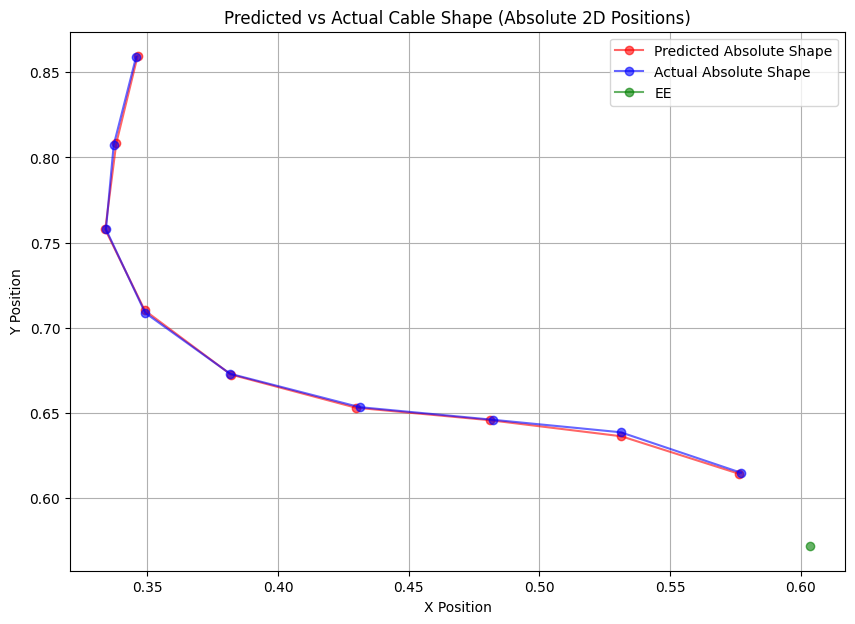

In [ ]:
model.eval()  # Set the model to evaluation mode

# Define the range and step size for indices to evaluate
start_idx = 50
step = 250
end_idx = len(dataset) - 250

# Initialize lists to store errors
velocity_error_list = []  # List to store velocity errors
shape_error_list = []  # List to store shape errors
max_error_list = []  # List to store maximum errors
min_error_list = []  # List to store minimum errors

# Loop through the dataset at specified intervals
for idx in range(start_idx, end_idx, step):
        # Get the input and target data for the current index
        inputs, targets = dataset[idx]

        # Move inputs and targets to the specified device (CPU or GPU)
        inputs = inputs.to(device).unsqueeze(0)  # Add batch dimension: (1, num_markers, features)
        targets = targets.to(device).float()  # Convert targets to float: (num_markers, 2)

        with torch.no_grad():  # Disable gradient computation for evaluation
                outputs = model(inputs)  # Forward pass through the model
                predictions = outputs.squeeze(0)  # Remove batch dimension: (num_markers, 2)

        # Get the normalized end-effector (EE) position
        EE_pos_x, EE_pos_y = dataset.EE_pos_normalized[idx, :2]
        basis_position = torch.tensor([EE_pos_x, EE_pos_y], device=device)

        # Define mean and standard deviation for velocity normalization
        cable_vel_mean = torch.tensor([-7.6191895e-08,  5.4330588e-08]).to(device)
        cable_vel_std = torch.tensor([0.007593654096126556, 0.006266195327043533]).to(device)

        # Denormalize predictions and targets
        prediction_entnorm = predictions * cable_vel_std + cable_vel_mean
        target_entnorm = targets * cable_vel_std + cable_vel_mean

        # Calculate velocity error and append to the list
        velocity_error_prediction = velocity_error(target_entnorm, prediction_entnorm)
        velocity_error_list.append(velocity_error_prediction)

        # Calculate absolute positions for predictions and targets
        pred_abs = dataset.get_absolute_coords(idx).view(9, 2) + prediction_entnorm
        target_abs = dataset.get_absolute_coords(idx).view(9, 2) + target_entnorm

        # Calculate shape error and append to the list
        e_shape = torch.norm(pred_abs - target_abs, p=2)
        shape_error_list.append(e_shape)

        # Calculate maximum and minimum errors and append to their respective lists
        max_error = (pred_abs - target_abs).norm(dim=1).max()
        min_error = (pred_abs - target_abs).norm(dim=1).min()
        max_error_list.append(max_error)
        min_error_list.append(min_error)

        # Get the absolute EE position
        EE_pos_x, EE_pos_y = dataset.EE_pos[idx, :2]
        basis_position = torch.tensor([EE_pos_x, EE_pos_y], device=device)
        basis_position = basis_position.view(1, 2)

# Calculate and print the maximum error if the list is not empty
if max_error_list:
    max_error_mean = np.max(max_error_list)
    print('Max Error in m: ', max_error_mean)
else:
    print('Max Error in m: No data available')

# Calculate and print the minimum error if the list is not empty
if min_error_list:
    min_error_mean = np.min(min_error_list)
    print('Min Error in m: ', min_error_mean)
else:
    print('Min Error in m: No data available')

# Calculate and print the mean velocity error if the list is not empty
if velocity_error_list:
    vel_error_mean = np.mean(velocity_error_list)
    print(f"Mean Velocity Error in %: {vel_error_mean}")
else:
    print('Mean Velocity Error in %: No data available')

# Calculate and print the mean shape error if the list is not empty
if shape_error_list:
    shape_error_mean = np.mean(shape_error_list)
    print(f"Mean Shape Error in m: {shape_error_mean}")
else:
    print('Mean Shape Error in m: No data available')

# Plot the predicted and actual cable shapes
fig, ax = plt.subplots(figsize=(10, 7))

# Plot predicted absolute shape
ax.plot(pred_abs[:, 0].cpu().numpy(), pred_abs[:, 1].cpu().numpy(),
                color='red', alpha=0.6, marker='o', label='Predicted Absolute Shape')

# Plot actual absolute shape
ax.plot(target_abs[:, 0].cpu().numpy(), target_abs[:, 1].cpu().numpy(),
                color='blue', alpha=0.6, marker='o', label='Actual Absolute Shape')

# Plot end-effector position
ax.plot(basis_position[:, 0].cpu().numpy(), basis_position[:, 1].cpu().numpy(),
                color='green', alpha=0.6, marker='o', label='EE')

# Set plot labels and title
ax.set_xlabel('X Position')
ax.set_ylabel('Y Position')
ax.set_title('Predicted vs Actual Cable Shape (Absolute 2D Positions)')

# Add legend and grid
ax.legend()
ax.grid(True)

# Display the plot
plt.show()

In [27]:
device = torch.device("cpu")
model.load_state_dict(torch.load("models/BEST_bi_LSTM_2_rel_vel_bs128_hs256_lr00001_nl3_epochs50_10k.pth", weights_only=True, map_location=device)) #
model.to(device)
file_path = '/home/lukas-zeh/Documents/GNN_CableSimulation/simulationData/simulation_data_rollout.npz'
rollout_dataset = SimulationDataset(file_path)


KeyError: 'EE_pos is not a file in the archive'

In [26]:
# Function to calculate relative positions of markers with respect to the end-effector (EE)
def get_local_relativ_positions(idx, coords, normalize=False):
    relative_DLO = coords

    # Get the position of the end-effector (EE) for the given index
    EE_pos = dataset.EE_pos[idx, :2]
    # Calculate relative positions of markers with respect to the EE
    rel_positions = coords - EE_pos.unsqueeze(0)  # (9, 2)

    if normalize:
        # Normalize the relative positions using L2 norm
        l2_norm = torch.norm(rel_positions, dim=1, keepdim=True)
        l2_norm[l2_norm == 0] = 1e-9  # Avoid division by zero
        rel_positions = rel_positions / l2_norm

    return rel_positions

# Function to perform a rollout of the model for a given number of steps
def rollout_velocity(model, dataset, rollout_steps=10):
    max_idx = len(dataset) - 1 - rollout_steps
    # Randomly select an index for the rollout
    random_idx = random.randint(0, max_idx)
    inputs, targets = dataset[random_idx]
    model.eval()  # Set the model to evaluation mode

    # Get the initial positions of the cable markers
    coords = dataset.cable_pos[random_idx, :, :2]
    coords = coords[6:-3]  # Select a subset of markers
    new_abs_position = coords[::5]  # Downsample the markers
    traj = new_abs_position  # Initialize trajectory
    trajectories = []  # List to store predicted trajectories
    ground_truth_list = []  # List to store ground truth trajectories
    EE_Pos_list = []  # List to store EE positions
    velocity_error_list = []  # List to store velocity errors
    shape_error_list = []  # List to store shape errors

    # Mean and standard deviation for velocity normalization
    cable_vel_mean = np.array([-7.6191895e-08,  5.4330588e-08])
    cable_vel_std  = np.array([0.007593654096126556, 0.006266195327043533])

    for step in range(rollout_steps):
        with torch.no_grad():  # Disable gradient computation for inference
            # Get the normalized robot state (position and velocity)
            current_robot_state_pos = dataset.EE_pos_normalized[random_idx + step].unsqueeze(0).repeat(dataset.num_markers, 1)  # (num_markers, 4)
            current_robot_state_vel = dataset.EE_vel_normalized[random_idx + step].unsqueeze(0).repeat(dataset.num_markers, 1)  # (num_markers, 4)
            current_robot_state = torch.cat((current_robot_state_pos, current_robot_state_vel), dim=1)  # (num_markers, 8)

            if step == 0:
                # Get normalized relative positions for the first step
                normalized_relative_DLO = get_local_relativ_positions(idx=random_idx + step, coords=new_abs_position, normalize=True)
                velocity_prediction = dataset.get_norm_marker_velocity(random_idx)
            else:
                # Calculate normalized relative positions for subsequent steps
                EE_pos = dataset.EE_pos[random_idx + step, :2]
                current_relative_dlo_state = new_abs_position - EE_pos
                norms = torch.norm(current_relative_dlo_state, dim=1, keepdim=True)  # => shape (8, 1)
                normalized_relative_DLO = current_relative_dlo_state / (norms + 1e-9)

            # Combine relative positions and velocity predictions
            current_dlo_velocity = velocity_prediction
            current_relative_dlo_state = torch.cat((normalized_relative_DLO, current_dlo_velocity), dim=1)
            # Combine robot state and DLO state as input to the model
            inputs = torch.cat((current_robot_state, current_relative_dlo_state), dim=1)
            inputs = inputs.float()

            # Predict the velocity using the model
            velocity_prediction = model(inputs)
            # Denormalize the predicted velocity
            new_velocity = (velocity_prediction * cable_vel_std) + (cable_vel_mean + 1e-9)

            if step == 0:
                # Get the absolute positions for the first step
                new_abs_position = dataset.get_absolute_coords(random_idx + step).view(9, 2)
            else:
                # Update the absolute positions using the predicted velocity
                new_abs_position = new_abs_position + new_velocity

            # Get the ground truth for the current step
            inputs_dummy, ground_truth = dataset[random_idx + step]
            ground_truth_entnorm = (targets * cable_vel_std) + (cable_vel_mean + 1e-9)
            ground_truth = dataset.get_absolute_coords(random_idx + step).view(9, 2) + ground_truth_entnorm

            # Store the EE position
            EE_pos_x, EE_pos_y = dataset.EE_pos[random_idx + step, :2]
            basis_position = torch.tensor([EE_pos_x, EE_pos_y], device=device)
            basis_position = basis_position.view(1, 2)
            EE_Pos_list.append(basis_position.numpy())

            # Append ground truth and predicted trajectory
            ground_truth_list.append(ground_truth.numpy())
            trajectories.append(new_abs_position.numpy())

            # Calculate velocity error and shape error
            velocity_error_prediction = velocity_error(ground_truth_entnorm, new_velocity.view(9, 2))
            velocity_error_list.append(velocity_error_prediction)
            e_shape = torch.norm(new_abs_position - ground_truth, p=2)
            shape_error_list.append(e_shape)

            # Update the trajectory
            traj = torch.cat((traj, new_abs_position), dim=1)

    return trajectories, ground_truth_list, EE_Pos_list, velocity_error_list, shape_error_list

# Perform a rollout with the model and dataset
traj, gr_true, EE_list, velocity_error_list, shape_error_list = rollout_velocity(model, dataset=rollout_dataset, rollout_steps=50)

# Print velocity and shape errors
print("velocity_error_list", velocity_error_list)
print("shape_error_list", shape_error_list)

# Convert trajectories, ground truth, and EE positions to numpy arrays
traj = np.array(traj)
gr_true = np.array(gr_true)
ee_pos = np.array(EE_list)

# Plot the trajectories and ground truth
plt.figure(figsize=(8, 6))
for i in range(0, len(traj), 49):  # Plot every 49th trajectory
    trajectory = traj[i]
    ground_truth = gr_true[i]
    ee_position = ee_pos[i]

    # Extract x and y coordinates
    x, y = trajectory[:, 0], trajectory[:, 1]
    x_g, y_g = ground_truth[:, 0], ground_truth[:, 1]
    x_e, y_e = ee_position[:, 0], ee_position[:, 1]

    # Plot predicted trajectory and ground truth
    plt.plot(x, y, marker='o', color='b', linestyle='-', linewidth=6)
    plt.plot(x_g, y_g, marker='o', color='r', linestyle='-', linewidth=6, alpha=0.4)

# Add labels and grid to the plot
plt.xlabel('X-Coordinate', fontsize=14)
plt.ylabel('Y-Coordinate', fontsize=14)
plt.grid(True)
plt.show()



NameError: name 'rollout_dataset' is not defined

In [22]:
# Get the last index of the trajectory
i = len(traj) - 1  # Last index of 'traj'

# Extract the trajectory, ground truth, and end-effector position for the last step
trajectory = traj[i]  # Predicted trajectory at the last step
ground_truth = gr_true[i]  # Ground truth trajectory at the last step
ee_position = ee_pos[i]  # End-effector position at the last step

# Extract x and y coordinates for the predicted trajectory
x, y = trajectory[:, 0], trajectory[:, 1]

# Extract x and y coordinates for the ground truth trajectory
x_g, y_g = ground_truth[:, 0], ground_truth[:, 1]

# Extract x and y coordinates for the end-effector position
x_e, y_e = ee_position[:, 0], ee_position[:, 1]

# Create a plot to visualize the predicted and ground truth trajectories
plt.figure(figsize=(8, 6))

# Plot the predicted trajectory
plt.plot(x, y, marker='o', color='b', linestyle='-', linewidth=6, label='Predicted Trajectory')

# Plot the ground truth trajectory
plt.plot(x_g, y_g, marker='o', color='r', linestyle='-', linewidth=6, alpha=0.4, label='Ground Truth Trajectory')

# Add labels and grid to the plot
plt.xlabel('X-Coordinate', fontsize=14)  # Label for x-axis
plt.ylabel('Y-Coordinate', fontsize=14)  # Label for y-axis
plt.grid(True)  # Add grid to the plot

# Add a legend to differentiate between predicted and ground truth trajectories
plt.legend()

# Display the plot
plt.show()


NameError: name 'traj' is not defined

In [23]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import numpy as np
from IPython.display import HTML

def create_animation(traj, gr_true, ee_pos):
    """
    Creates an animation to visualize the predicted trajectory, ground truth, and end-effector position.

    Parameters:
    - traj: Predicted trajectory (3D array of shape [Steps, Markers, Coordinates])
    - gr_true: Ground truth trajectory (3D array of shape [Steps, Markers, Coordinates])
    - ee_pos: End-effector positions (2D array of shape [Steps, Coordinates])

    Returns:
    - HTML object containing the animation.
    """
    # Ensure the end-effector position has the correct shape
    ee_pos = ee_pos.squeeze(1)

    # Debugging: Print shapes of input arrays
    print("Shape of traj:", traj.shape)
    print("Shape of gr_true:", gr_true.shape)
    print("Shape of ee_pos:", ee_pos.shape)

    # Assertions to ensure input dimensions are correct
    assert traj.ndim == 3, "traj should be 3D: (Steps, Markers, Coordinates)"
    assert gr_true.ndim == 3, "gr_true should be 3D: (Steps, Markers, Coordinates)"
    assert ee_pos.ndim == 2, "ee_pos should be 2D: (Steps, Coordinates)"

    # Flatten all data to calculate global min and max for x and y axes
    all_pred = traj.reshape(-1, 2)  # Flatten predicted trajectory
    all_true = gr_true.reshape(-1, 2)  # Flatten ground truth trajectory
    all_ee = ee_pos  # End-effector positions

    # Calculate axis limits with some padding
    min_x = min(np.min(all_pred[:, 0]), np.min(all_true[:, 0]), np.min(all_ee[:, 0])) - 0.1
    max_x = max(np.max(all_pred[:, 0]), np.max(all_true[:, 0]), np.max(all_ee[:, 0])) + 0.1
    min_y = min(np.min(all_pred[:, 1]), np.min(all_true[:, 1]), np.min(all_ee[:, 1])) - 0.1
    max_y = max(np.max(all_pred[:, 1]), np.max(all_true[:, 1]), np.max(all_ee[:, 1])) + 0.1

    # Create a figure and axis for the animation
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.set_xlim(min_x, max_x)  # Set x-axis limits
    ax.set_ylim(min_y, max_y)  # Set y-axis limits
    ax.set_title('Trajektorien Animation')  # Title of the plot
    ax.set_xlabel('X-Koordinate')  # Label for x-axis
    ax.set_ylabel('Y-Koordinate')  # Label for y-axis
    ax.grid(True)  # Add grid to the plot

    # Initialize plot elements for predicted trajectory, ground truth, and end-effector
    pred_line, = ax.plot([], [], 'bo-', ms=4, alpha=1, linewidth=2, label='Vorhersage')  # Predicted trajectory
    true_line, = ax.plot([], [], 'ro-', ms=4, alpha=0.5, linewidth=2, label='Ground Truth')  # Ground truth trajectory
    ee_line, = ax.plot([], [], 'rx', ms=8, label='Endeffektor')  # End-effector position
    ax.legend()  # Add legend to the plot

    def init():
        """
        Initialization function for the animation.
        Clears the data for all plot elements.
        """
        pred_line.set_data([], [])
        true_line.set_data([], [])
        ee_line.set_data([], [])
        return pred_line, true_line, ee_line

    def update(frame):
        """
        Update function for each frame of the animation.

        Parameters:
        - frame: Current frame index.

        Updates the data for predicted trajectory, ground truth, and end-effector position.
        """
        # Get the data for the current frame
        current_pred = traj[frame]  # Predicted trajectory for the current frame
        current_true = gr_true[frame]  # Ground truth trajectory for the current frame
        current_ee = ee_pos[frame]  # End-effector position for the current frame

        # Update the plot elements with the current data
        pred_line.set_data(current_pred[:, 0], current_pred[:, 1])  # Update predicted trajectory
        true_line.set_data(current_true[:, 0], current_true[:, 1])  # Update ground truth trajectory
        ee_line.set_data([current_ee[0]], [current_ee[1]])  # Update end-effector position

        return pred_line, true_line, ee_line

    # Create the animation using FuncAnimation
    ani = FuncAnimation(
        fig,
        update,  # Update function
        frames=traj.shape[0],  # Number of frames (steps in the trajectory)
        init_func=init,  # Initialization function
        blit=True,  # Use blitting for better performance
        interval=50,  # Interval between frames in milliseconds
        repeat=False  # Do not repeat the animation
    )

    plt.close(fig)  # Close the figure to prevent it from displaying as a static plot
    return HTML(ani.to_html5_video())  # Return the animation as an HTML video

# Create the animation and display it
animation = create_animation(traj, gr_true, ee_pos)
animation

NameError: name 'traj' is not defined

In [24]:
import time
import torch

# Number of warm-up iterations (not measured for timing)
num_warmup = 5

# Number of measured iterations (used for timing)
num_measure = 10

# List to store measured inference times
times = []

# Get a sample input and target from the dataset
inputs, targets = dataset[idx]

# Set the device to CUDA (GPU) for inference
device = 'cuda'

# Move inputs to the GPU and add a batch dimension
inputs = inputs.to(device).unsqueeze(0)  # Shape: (1, num_markers, features)

# Move targets to the GPU
targets = targets.to(device).float()  # Shape: (num_markers, 2)

# Move the model to the GPU
model = model.to(device)

# Measure inference time on GPU
for i in range(num_warmup + num_measure):
    # Synchronize CUDA to ensure accurate timing
    torch.cuda.synchronize() if torch.cuda.is_available() else None

    # Record the start time
    start_time = time.time()

    # Perform inference without computing gradients
    with torch.no_grad():
        output = model(inputs)

    # Synchronize CUDA again after inference
    torch.cuda.synchronize() if torch.cuda.is_available() else None

    # Record the end time
    end_time = time.time()

    # Skip warm-up iterations and record measured times
    if i >= num_warmup:
        times.append(end_time - start_time)

# Calculate mean and standard deviation of inference times on GPU
mean_time = np.mean(times) * 1e3  # Convert to milliseconds
std_time = np.std(times) * 1e3    # Convert to milliseconds
print(f"Mean Inference Time Cuda: {mean_time:.3f} ms")
print(f"Std Inference Time Cuda: {std_time:.3f} ms")

# Set the device to CPU for inference
device = 'cpu'

# Move the model to the CPU
model = model.to(device)

# Move inputs to the CPU
inputs = inputs.to(device)

# Measure inference time on CPU
for i in range(num_warmup + num_measure):
    # Synchronize CUDA (if available) to ensure accurate timing
    torch.cuda.synchronize() if torch.cuda.is_available() else None

    # Record the start time
    start_time = time.time()

    # Perform inference without computing gradients
    with torch.no_grad():
        output = model(inputs)

    # Synchronize CUDA again after inference
    torch.cuda.synchronize() if torch.cuda.is_available() else None

    # Record the end time
    end_time = time.time()

    # Skip warm-up iterations and record measured times
    if i >= num_warmup:
        times.append(end_time - start_time)

# Calculate mean and standard deviation of inference times on CPU
mean_time = np.mean(times) * 1e3  # Convert to milliseconds
std_time = np.std(times) * 1e3    # Convert to milliseconds
print(f"Mean Inference Time Cpu: {mean_time:.3f} ms")
print(f"Std Inference Time Cpu: {std_time:.3f} ms")

Mean Inference Time Cuda: 0.549 ms
Std Inference Time Cuda: 0.008 ms
Mean Inference Time Cpu: 1.366 ms
Std Inference Time Cpu: 0.817 ms
